# SMS Spam Collection

Qëllimi i këtij projekti është të zhvillojmë dhe trajnojmë një model të mësimit të makinës që mund të diferencojë mesazhet e dëshiruara (ham) dhe ato të padëshiruara (spam) në një koleksion të madh të mesazheve SMS. Duke përdorur teknika të ndryshme të përpunimit të gjuhës natyrore dhe modele të mësimit të makinës, synojmë të arrijmë një saktësi të lartë në parashikimin e kategorisë së secilit mesazh. Kjo mundëson filtrimin efikas të mesazheve spam dhe përmirëson përvojën e përdoruesit duke minimizuar ndërhyrjet e padëshiruara. 

### Libraritë e përdorura

In [119]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow.keras as keras



In [118]:
# Define input and output file paths
input_file = "SMSSpamCollection.csv"
output_file = "SMS_Spam_Collection.csv"

# Open input and output files
with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    # Create CSV writer
    writer = csv.writer(outfile)
    
    # Iterate over lines in the input file
    for line in infile:
        # Split line into label and message
        label, message = line.strip().split('\t')
        
        # Write label and message to CSV file
        writer.writerow([label, message])

print("Dataset successfully converted to CSV.")


Dataset successfully converted to CSV.


### Leximi i dataset-it

In [120]:
# Leximi i dataset-it
df = pd.read_csv("SMS_Spam_Collection.csv")

### Metodat ndihmëse

In [121]:
# Funksioni për të hedhur një vështrim në rreshtat e parë të dataset-it.
def printo_datasetin(text, df):
    print("\n" + text + ":")
    display(df.head())

## FAZA 1

### Kualiteti i të dhënave 

- Struktura e bazës së të dhënave

In [122]:
# Shfaqja e dataseti-it
printo_datasetin("Dataset-i", df)


Dataset-i:


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- Njohuri mbi llojet e të dhënave

In [123]:
# Për të fituar njohuri mbi llojet e të dhënave ekzekutojmë këtë komandë:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


- Kontrollimi i vlerave null

In [124]:
# Komanda për kontrollimin e vlerave null:
df.isnull().sum()

Label      0
Message    0
dtype: int64

- Kërkimi i duplikatëve

In [125]:
# Komanda për kërkimin e duplikateve dhe shfaqja e rezultatit
print("Duplikatet: " + str(df.duplicated().sum()))

Duplikatet: 414


- Fshirja e duplikateve

In [126]:
# Fshirja e duplikateve
df.drop_duplicates(['Label', 'Message'], keep='first', inplace=True)

# Ruajtja e të dhënave të pastruara në new_df
new_df = df.copy()

# Kërkimi përsëri i duplikateve dhe shfaqja e rezultatit
print("Duplikatet: " + str(new_df.duplicated().sum()))


Duplikatet: 0


- Mostrimi i të dhënave

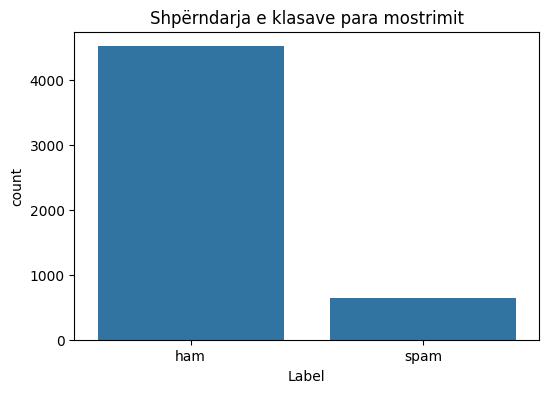

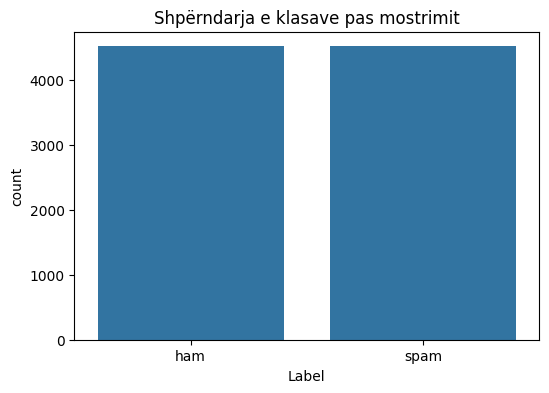

In [74]:
df = pd.DataFrame(new_df)

# Vizualizimi i shpërndarjes së klasave para mostrimit
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df)
plt.title('Shpërndarja e klasave para mostrimit')
plt.show()

# Mostrimi për balancimin e klasave
df_majority = df[df['Label'] == 'ham']
df_minority = df[df['Label'] == 'spam']
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)
df_sampled = pd.concat([df_majority, df_minority_upsampled])

# Vizualizimi i shpërndarjes së klasave pas mostrimit
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df_sampled)
plt.title('Shpërndarja e klasave pas mostrimit')
plt.show()


- Agregimi i të dhënave

In [75]:
# Shtimi i kolonës së gjatësisë së mesazhit
df['Message_length'] = df['Message'].apply(len)

# Agregime të ndryshme
average_length = df['Message_length'].mean()
max_length = df['Message_length'].max()
min_length = df['Message_length'].min()

# Numri i mesazheve 'spam' dhe 'ham'
spam_count = df[df['Label'] == 'spam']['Label'].count()
ham_count = df[df['Label'] == 'ham']['Label'].count()

# Gjatësia mesatare e mesazheve për secilën kategori
average_length_spam = df[df['Label'] == 'spam']['Message_length'].mean()
average_length_ham = df[df['Label'] == 'ham']['Message_length'].mean()

print("Statistika të Përgjithshme:")
print(f"Gjatësia mesatare e mesazheve: {average_length:.2f}")
print(f"Gjatësia maksimale e mesazheve: {max_length}")
print(f"Gjatësia minimale e mesazheve: {min_length}")
print(f"Numri i mesazheve 'spam': {spam_count}")
print(f"Numri i mesazheve 'ham': {ham_count}")
print("Gjatësia mesatare e mesazheve sipas kategorisë:")
print(f"Spam: {average_length_spam:.2f}")
print(f"Ham: {average_length_ham:.2f}")


Statistika të Përgjithshme:
Gjatësia mesatare e mesazheve: 79.14
Gjatësia maksimale e mesazheve: 910
Gjatësia minimale e mesazheve: 2
Numri i mesazheve 'spam': 642
Numri i mesazheve 'ham': 4518
Gjatësia mesatare e mesazheve sipas kategorisë:
Spam: 137.41
Ham: 70.86


- Identifikimi i Outliers

c:\Users\vlorasht\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


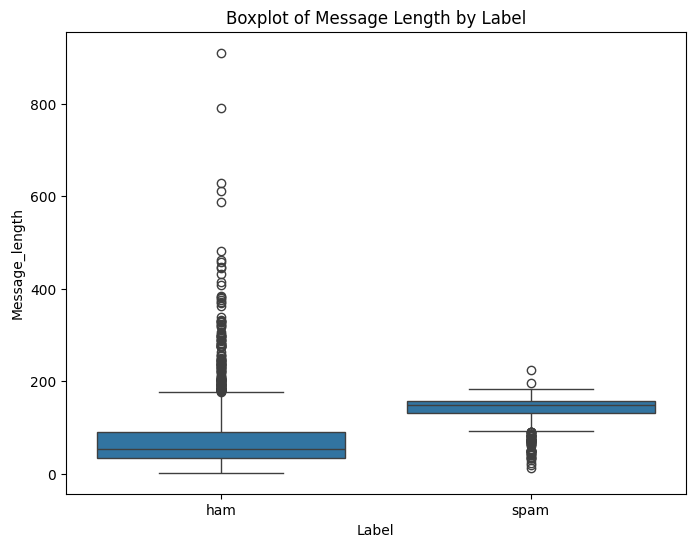

In [76]:
# Shtimi i kolonës për gjatësinë e mesazhit
df['Message_length'] = df['Message'].apply(len)

# Vizualizimi i një boxplot për gjatësinë e mesazheve
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Message_length', data=df)
plt.title('Boxplot of Message Length by Label')
plt.show()


- Përdorimi i IQR për të identifikuar dhe fshirë outliers

c:\Users\vlorasht\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


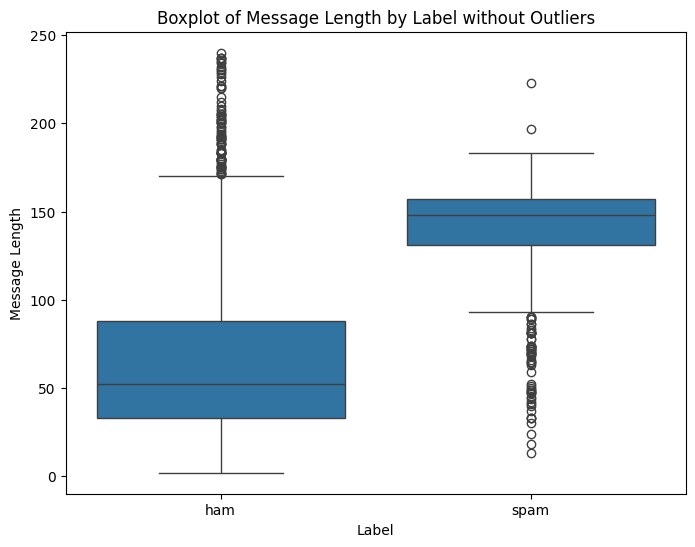

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supozojmë se 'df' është DataFrame-i juaj që përmban kolonat 'Label' dhe 'Message'
# Shtimi i kolonës së gjatësisë së mesazhit
df['Message_length'] = df['Message'].apply(len)

# Llogaritja e IQR për të identifikuar outliers
Q1 = df['Message_length'].quantile(0.25)
Q3 = df['Message_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifikimi dhe heqja e outliers
outliers = df[(df['Message_length'] < lower_bound) | (df['Message_length'] > upper_bound)]
new_df = df[(df['Message_length'] >= lower_bound) & (df['Message_length'] <= upper_bound)]

# Vizualizimi i një boxplot të gjatësisë së mesazheve pa outliers në new_df
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Message_length', data=new_df)
plt.title('Boxplot of Message Length by Label without Outliers')
plt.xlabel('Label')
plt.ylabel('Message Length')
plt.show()



- Aplikimi i SMOTE

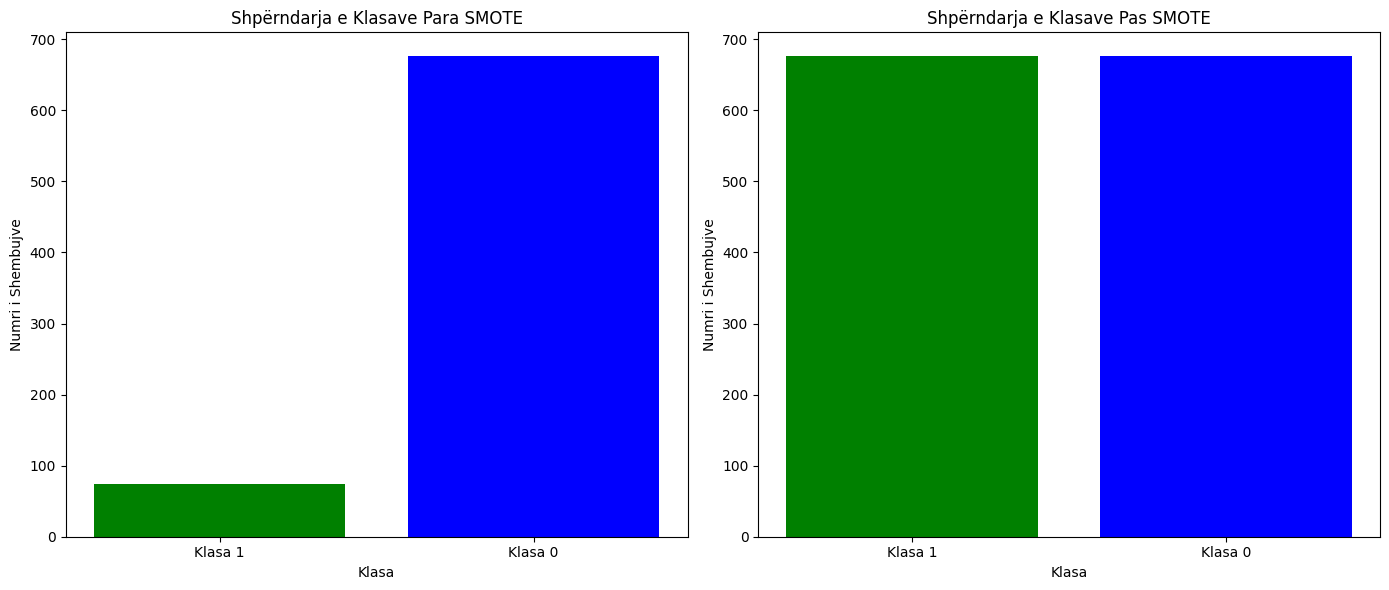

In [78]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Gjenerimi i një dataseti të thjeshtë për demonstrim
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

# Ndajmë të dhënat në trajnues dhe testim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Inicializimi i SMOTE
sm = SMOTE(random_state=42)

# Aplikimi i SMOTE në të dhënat e trajnimit
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Llogaritja e shpërndarjes së klasave para dhe pas SMOTE
class_distribution_before = Counter(y_train)
class_distribution_after = Counter(y_train_res)

# Vizualizimi
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_distribution_before.keys(), class_distribution_before.values(), color=['blue', 'green'])
ax[0].set_title('Shpërndarja e Klasave Para SMOTE')
ax[0].set_xlabel('Klasa')
ax[0].set_ylabel('Numri i Shembujve')
ax[0].set_xticks(list(class_distribution_before.keys()))
ax[0].set_xticklabels(['Klasa 0', 'Klasa 1'])

ax[1].bar(class_distribution_after.keys(), class_distribution_after.values(), color=['blue', 'green'])
ax[1].set_title('Shpërndarja e Klasave Pas SMOTE')
ax[1].set_xlabel('Klasa')
ax[1].set_ylabel('Numri i Shembujve')
ax[1].set_xticks(list(class_distribution_after.keys()))
ax[1].set_xticklabels(['Klasa 0', 'Klasa 1'])

plt.tight_layout()
plt.show()


## FAZA 2


### Trajnimi dhe testimi i të dhënave

In [127]:
# Përgatitja dhe pastrimi i të dhënave
df = df[['Label', 'Message']]
df.columns = ['Label', 'Message']

# Ndajmë të dhënat në trajnues dhe testim
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Label'], test_size=0.2, random_state=42)

# Përdorimi i TF-IDF Vectorizer për të kthyer tekstet në një format të përpunueshëm numerik
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Trajnojmë modelin duke përdorur Naive Bayes
model = MultinomialNB()
model.fit(X_train_transformed, y_train)

# Parashikimi dhe vlerësimi i modelit
predictions = model.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.9563953488372093
Confusion Matrix:
 [[916   0]
 [ 45  71]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98       916
        spam       1.00      0.61      0.76       116

    accuracy                           0.96      1032
   macro avg       0.98      0.81      0.87      1032
weighted avg       0.96      0.96      0.95      1032



### Gradient Boosting Classifier

In [128]:

# Trajnojmë modelin duke përdorur Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gbc.fit(X_train_transformed, y_train)

# Parashikimi dhe vlerësimi i modelit
gbc_predictions = gbc.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, gbc_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, gbc_predictions))
print("Classification Report:\n", classification_report(y_test, gbc_predictions))


Accuracy: 0.935077519379845
Confusion Matrix:
 [[890  26]
 [ 41  75]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.96      0.97      0.96       916
        spam       0.74      0.65      0.69       116

    accuracy                           0.94      1032
   macro avg       0.85      0.81      0.83      1032
weighted avg       0.93      0.94      0.93      1032



### K Neighbors Classifier

In [129]:
from sklearn.neighbors import KNeighborsClassifier

# Trajnojmë modelin përdorur KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_transformed, y_train)

# Parashikimi dhe vlerësimi i modelit
knn_predictions = knn.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))


Accuracy: 0.9302325581395349
Confusion Matrix:
 [[916   0]
 [ 72  44]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.93      1.00      0.96       916
        spam       1.00      0.38      0.55       116

    accuracy                           0.93      1032
   macro avg       0.96      0.69      0.76      1032
weighted avg       0.94      0.93      0.92      1032



### Logistic Regression

In [130]:
lr_model = LogisticRegression()
lr_model.fit(X_train_transformed, y_train)
lr_predictions = lr_model.predict(X_test_transformed)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))

Logistic Regression Accuracy: 0.9660852713178295


### Support Vector Machine (SVM)

In [131]:
svm_model = SVC()
svm_model.fit(X_train_transformed, y_train)
svm_predictions = svm_model.predict(X_test_transformed)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

SVM Accuracy: 0.9757751937984496


### Decision Trees Classifier

In [132]:
# Trajnojmë modelin përdorur Decision Tree
dtc = DecisionTreeClassifier(max_depth=5, random_state=42)
dtc.fit(X_train_transformed, y_train)

# Parashikimi dhe vlerësimi i modelit
dtc_predictions = dtc.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, dtc_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, dtc_predictions))
print("Classification Report:\n", classification_report(y_test, dtc_predictions))


Accuracy: 0.9408914728682171
Confusion Matrix:
 [[890  26]
 [ 35  81]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.96      0.97      0.97       916
        spam       0.76      0.70      0.73       116

    accuracy                           0.94      1032
   macro avg       0.86      0.83      0.85      1032
weighted avg       0.94      0.94      0.94      1032



In [133]:
# Data Preparation for Model Training
## Text Vectorization with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Message'])
y = df['Label']

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training and Evaluation
## Train Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9631782945736435
Confusion Matrix:
 [[916   0]
 [ 38  78]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       916
        spam       1.00      0.67      0.80       116

    accuracy                           0.96      1032
   macro avg       0.98      0.84      0.89      1032
weighted avg       0.96      0.96      0.96      1032



### Additional Models and Cross-Validation

In [134]:
# Training Additional Models
## Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))

## Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))


# Cross-Validation Example
models = [MultinomialNB(), LogisticRegression(), SVC()]
model_names = ['Naive Bayes', 'Logistic Regression', 'SVC']
for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name} Accuracy: {np.mean(scores)}")

Logistic Regression Accuracy: 0.9515503875968992
SVM Accuracy: 0.9680232558139535
Naive Bayes Accuracy: 0.9619666886785531
Logistic Regression Accuracy: 0.9401640619267738
SVC Accuracy: 0.9656001173967276


In [135]:
# Transforming text into numerical data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(new_df['Message'])
y = new_df['Label'].apply(lambda x: 1 if x == 'spam' else 0)

# Different test sizes for model evaluation
splits = [0.4, 0.3, 0.2, 0.1]  # Test sizes

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Support Vector Machine': SVC(kernel='linear'),
    'K Neighbors': KNeighborsClassifier()
}

# Evaluating each model with each split
for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    print(f"\nEvaluating models with a train/test split of {int((1-split)*100)}/{int(split*100)}")

    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        print(f"{name} - Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")



Evaluating models with a train/test split of 60/40
Logistic Regression - Accuracy: 0.95, F1-score: 0.72, Recall: 0.57, Precision: 0.99
Decision Tree - Accuracy: 0.96, F1-score: 0.84, Recall: 0.82, Precision: 0.85
Random Forest - Accuracy: 0.97, F1-score: 0.88, Recall: 0.78, Precision: 0.99
Support Vector Machine - Accuracy: 0.98, F1-score: 0.89, Recall: 0.82, Precision: 0.98
K Neighbors - Accuracy: 0.90, F1-score: 0.26, Recall: 0.15, Precision: 1.00

Evaluating models with a train/test split of 70/30
Logistic Regression - Accuracy: 0.95, F1-score: 0.73, Recall: 0.58, Precision: 0.97
Decision Tree - Accuracy: 0.95, F1-score: 0.80, Recall: 0.81, Precision: 0.78
Random Forest - Accuracy: 0.98, F1-score: 0.88, Recall: 0.79, Precision: 0.99
Support Vector Machine - Accuracy: 0.98, F1-score: 0.89, Recall: 0.83, Precision: 0.95
K Neighbors - Accuracy: 0.91, F1-score: 0.31, Recall: 0.19, Precision: 1.00

Evaluating models with a train/test split of 80/20
Logistic Regression - Accuracy: 0.96, 